# SHARK QUEST
## New Kids On The Block



# TODO

- Pickle ?
- Column names?

## Selecting
- Select relevant columns
- Analyse relevant columns

## Cleaning :
- Cast to appropriate data types
    - General cleaning
        - identify duplicates
            - fuzzy
        - removing duplicates
            - remove
            - merge
        - handling null values
            - remove
            - replace
        - manipulating strings
        - formatting the data.

- Wrong inputs
- Outliers

## Hypothesis

### TIME
- Shark attacks are seasonal (Summer)
- Shark attacks are increasing 
- Shark attacks are more concentrated in the PM 

### LOCATION
- Some countries are more attack prone (Australia)
- Some countries are more likely to be fatal (Australia)


### DEMOGRAPHICS
- Males are more likely to get attacked
- Males are more likely to get provoke a shark
- Provoked attacked are more fatal
- Young persons are more likely to get attacked
- Old persons are more likely to get killed

- Names more likely to get attacked (John)

### OTHER
- Some species are more aggressive (Tiger Shark)
- Some activities are more likely (Surfing)
- Some activities are more fatal

- Full moon? 😂


## Business Ideas

- App that gives a likelyhood of attack based on location and time
- Vacations far away from sharks for phobics
- Witness attacks for masochists

- Surf school at the safest places / seasons
- Fishing supplies => shark repellant by activities
- Safety training to avoid provocations / live in harmony

- Shark repellant => best spots
- Insurance for surfers, premiums for high risk areas

### GENERAL CLEANING
1. Rename columns
2. Drop columns
3. Remove duplicates
    - Remove full dupes
    - Remove fuzzy search
4. Strip values
5. Reset Index

### SPECIFIC CLEANING
1. Search / Replace / Reformat strings
2. Merge categories
3. Cast to Null
4. Cast correct type
5. Create new columns


In [555]:
#import depedencies
import pandas as pd
import numpy as np
import re
import json
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [556]:
# Load the data
shark_attacks_df = pd.read_excel('GSAF5.xls')
shark_attacks = shark_attacks_df.copy()

countries_df = pd.read_csv('country_coord.csv')
countries = countries_df.copy()

shark_attacks.head()
shark_attacks.dtypes


Date               object
Year              float64
Type               object
Country            object
State              object
Location           object
Activity           object
Name               object
Sex                object
Age                object
Injury             object
Unnamed: 11        object
Time               object
Species            object
Source             object
pdf                object
href formula       object
href               object
Case Number        object
Case Number.1      object
original order    float64
Unnamed: 21        object
Unnamed: 22        object
dtype: object

In [557]:
# Settings
pd.set_option('display.max_rows', 80)
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_colwidth', 100)

In [558]:
# Format all columns names
shark_attacks.columns = [col.strip().replace(" ", "_").replace(".", "").lower() for col in shark_attacks.columns]

In [559]:

# Functions

def merge_values(row, arg1, *args):
    if row in args:
        return arg1
    else:
        return row


def strip_values(df):
    for col in df.columns:
        df[col] = df[col].apply(
            lambda x: x.strip() if isinstance(x, str) else x)
    return df


def replace_to_nan(series, keys, value=np.nan):
    """
    input series as dataframe['Column']
    input keys as a list of all the keys to replace
    input value as the replacer value for the keys, default is NaN
    """

    return series.replace(keys, value, inplace=True)


def categorize_activity(activity):
    if pd.isna(activity):
        return "Invalid"

    activity = activity.lower()

    for pattern, label in categories:
        if re.search(pattern, activity):
            return label

    return "Other Activity"


def replace_string_patterns(value, replacements):

    if isinstance(value, str):

        for pattern, result in replacements:
            value = re.sub(pattern, result, value)
        return value

    else:

        return value
    
def json_to_dict(json_filename):
    with open(json_filename+".json", "r") as json_file:
        data = json.load(json_file)
    return data


In [560]:
# Contract

data_schema = json_to_dict('schema')

""" data_schema_in = {
    'type': {'dtype': 'category', 'categories': ['PROVOKED', 'UNPROVOKED', 'WATERCRAFT','INVALID']},
    'date': {'dtype': 'datetime64[ns]'},
    'country': {'dtype': 'string'},
    'state': {'dtype': 'string'},
    'location': {'dtype': 'string'},
    'activity': {'dtype': 'category', 'categories': ['SWIMMING', 'SURFING', 'FISHING', 'DIVING', 'PASSIVE', 'BOATING']},
    'severity': {'dtype': 'category', 'categories': ['FATALITY', 'INJURY', 'OTHER']},
    'time': {'dtype': 'category', 'categories': ['MORNING', 'NOON', 'AFTERNOON', 'DANW', 'NIGHT', 'DUSK']}
} """



" data_schema_in = {\n    'type': {'dtype': 'category', 'categories': ['PROVOKED', 'UNPROVOKED', 'WATERCRAFT','INVALID']},\n    'date': {'dtype': 'datetime64[ns]'},\n    'country': {'dtype': 'string'},\n    'state': {'dtype': 'string'},\n    'location': {'dtype': 'string'},\n    'activity': {'dtype': 'category', 'categories': ['SWIMMING', 'SURFING', 'FISHING', 'DIVING', 'PASSIVE', 'BOATING']},\n    'severity': {'dtype': 'category', 'categories': ['FATALITY', 'INJURY', 'OTHER']},\n    'time': {'dtype': 'category', 'categories': ['MORNING', 'NOON', 'AFTERNOON', 'DANW', 'NIGHT', 'DUSK']}\n} "

In [561]:
#Creating new columns
shark_attacks['severity'] = shark_attacks_df['Injury']

In [562]:
# Selecting columns
shark_attacks = shark_attacks[[col for col in data_schema]]
shark_attacks


,type,date,country,state,location,activity,severity,time
0,Unprovoked,15 Mar 2024,AUSTRALIA,Queensland,Bargara Beach,Swimming,"Minor injuries to back, abdomen and legs",16h00
1,Unprovoked,04 Mar 2024,USA,Hawaii,"Old Man's, Waikiki",Surfing,"No injury, shark bit surfboard",NaN
2,Unprovoked,02 Mar-2024,USA,Hawaii,"Rainbows, Oahu",Swimming,Lacerations to left foot,13h30
3,Unprovoked,25 Feb-2024,AUSTRALIA,Western Australia,"Sandlnd Island, Jurian Bay",NaN,Leg bitten,11h30
4,Unprovoked,14 Feb-2024,INDIA,Maharashtra,"Vaitarna River, Palghar District",Fishing,Calf of lower left leg injured,NaN
...,...,...,...,...,...,...,...,...
6964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [563]:
# Strip strings
shark_attacks = shark_attacks.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)

In [564]:
#Handling missing values
shark_attacks.replace(['N/A', 'null', '--'], np.nan, inplace=True)

In [565]:
#Remove duplicates
#Drop complete duplicates
shark_attacks.drop_duplicates(keep=False, inplace=True)

In [566]:
#Reset Index
shark_attacks.reset_index(inplace=True)

In [567]:
# Reformat values
replacements = json_to_dict('replacements')

r""" replacements_in = {
    
    'type': [
        (r'^.*?(Provoked).*$', 'PROVOKED'),
        (r'^.*?(Unprovoked|Disaster).*$', 'UNPROVOKED'),
        (r'^.*?(Watercraft|Boat).*$', 'WATERCRAFT'),
    ],

    'activity': [
        (r'^.*?([Ss]wimming|[Ww]ading|[Bb]athing|[Ff]el|[Ss]plashing|[Ff]loat|[Dd]isaster|Dangling|Jump).*$', 'SWIMMING'),
        (r'^.*?([Sf]urf|[Bb]oard|[Pp]addl|[Ff]oil).*$', 'SURFING'),
        (r'^.*?([Dd]iving|[Ss]cuba|[Ss]norkel|[Sp]ear|[Ww]reck).*$', 'DIVING'),
        (r'^.*?([Bb]oat|[Sa]il|[Rr]ow|[Cc]raft|[Kk]ayak|[Cc]ano).*$', 'BOATING'),
        (r'^.*?(Fishing|Clam).*$', 'FISHING'),
        (r'^.*?([Ss]it|[Ss]tand|[Pp]lay|Murder|[Tt]read|[Ww]alk).*$', 'PASSIVE'),
    ],
    
    'time': [
        (r'^.*((0[0-2]|23)h|([nN]ight|[dD]ark)).*$', 'NIGHT'),
        (r'^.*((0[3-6])h|([dD]awn|[sS]unrise|[dD]aybreak)).*$', 'DAWN'),
        (r'^.*((0[7-9]|10)h.*$|([mM]orning|^[aA]\.?[mM])).*$', 'MORNING'),
        (r'^.*((1[1-4])h.*$|([nN]oon|[mM]idday|[lL]unch)).*$', 'NOON'),
        (r'^.*((1[5-8])h.*$|([aA]fternoon|^[pP]\.?[mM])).*$', 'AFTERNOON'),
        (r'^.*((19|2[0-2])h.*$|([dD]usk|[sS]unset|[eE]vening|[Ii]njured)).*$', 'DUSK'),
    ],
    
    'date': [
        (r'^(.*)(\d{2})(.*)(\w{3})(.*)(\d{4})(.*)', r'\2-\4-\6'),
        (r'^(.*)(\w{3})(.*)(\d{4})(.*)', r'01-\2-\4'),
        (r'-(uly|une)', r'-J\1'),
    ],
    
    'severity': [
        (r'^.*([Fa]tal|FATAL|[Kk]illed).*$', r'FATALITY'),
        (r'^.*(^[Ii]nju|[Bb]it|[Ss]urvived|[Ll]acer|[Mm]inor|[Ii]njured|[Aa]bra|[Pp]unct|[Mm]ultiple|[Ss]cratches|[Rr]iped|[Gg]ash).*$', r'INJURY'),
    ],
    
    'country': [
        (r'^.*([Fa]tal|FATAL|[Kk]illed).*$', r'FATALITY'),
    ],
}
 """

" replacements_in = {\n    \n    'type': [\n        (r'^.*?(Provoked).*$', 'PROVOKED'),\n        (r'^.*?(Unprovoked|Disaster).*$', 'UNPROVOKED'),\n        (r'^.*?(Watercraft|Boat).*$', 'WATERCRAFT'),\n    ],\n\n    'activity': [\n        (r'^.*?([Ss]wimming|[Ww]ading|[Bb]athing|[Ff]el|[Ss]plashing|[Ff]loat|[Dd]isaster|Dangling|Jump).*$', 'SWIMMING'),\n        (r'^.*?([Sf]urf|[Bb]oard|[Pp]addl|[Ff]oil).*$', 'SURFING'),\n        (r'^.*?([Dd]iving|[Ss]cuba|[Ss]norkel|[Sp]ear|[Ww]reck).*$', 'DIVING'),\n        (r'^.*?([Bb]oat|[Sa]il|[Rr]ow|[Cc]raft|[Kk]ayak|[Cc]ano).*$', 'BOATING'),\n        (r'^.*?(Fishing|Clam).*$', 'FISHING'),\n        (r'^.*?([Ss]it|[Ss]tand|[Pp]lay|Murder|[Tt]read|[Ww]alk).*$', 'PASSIVE'),\n    ],\n    \n    'time': [\n        (r'^.*((0[0-2]|23)h|([nN]ight|[dD]ark)).*$', 'NIGHT'),\n        (r'^.*((0[3-6])h|([dD]awn|[sS]unrise|[dD]aybreak)).*$', 'DAWN'),\n        (r'^.*((0[7-9]|10)h.*$|([mM]orning|^[aA]\\.?[mM])).*$', 'MORNING'),\n        (r'^.*((1[1-4])h.*$|([nN]oon|[

In [568]:

for col, values in replacements.items():
    shark_attacks[col] = shark_attacks[col].apply(
        replace_string_patterns, replacements=values)
shark_attacks['country']
    

0                AUSTRALIA
1                      USA
2                      USA
3                AUSTRALIA
4                    INDIA
               ...        
6893             AUSTRALIA
6894             AUSTRALIA
6895                   USA
6896                PANAMA
6897    CEYLON (SRI LANKA)
Name: country, Length: 6898, dtype: object

In [569]:
shark_attacks['country'] = shark_attacks['country'].apply(lambda x: x.lower() if isinstance(x, str) else x)
replace_to_nan(shark_attacks["country"], ["england","scotland"], "united kingdom")
replace_to_nan(shark_attacks["country"], ["usa", "hawaii"], "united states")
replace_to_nan(shark_attacks["country"], ["reunion"], "france")
replace_to_nan(shark_attacks["country"], ["columbia"], "colombia")
replace_to_nan(shark_attacks["country"], ["new guinea"], "papua new guinea")
display(shark_attacks['country'].value_counts())

display(countries)

# unify country, converts all low value "country" ocorrences into <NA>. Also sets Country as string-type
country_list = [x.lower() for x in countries['Country']]
display(country_list)
shark_attacks["country"] = shark_attacks["country"].where(shark_attacks["country"].isin(country_list), np.nan)
shark_attacks['country'].value_counts()

country
united states                     2524
australia                         1471
south africa                       598
papua new guinea                   146
new zealand                        145
                                  ... 
diego garcia                         1
federated states of micronesia       1
red sea                              1
british isles                        1
ceylon (sri lanka)                   1
Name: count, Length: 204, dtype: int64

,Country,Alpha-2 code,Alpha-3 code,Numeric code,Latitude,Longitude
0,Afghanistan,AF,AFG,4,33.0000,65.0
1,Albania,AL,ALB,8,41.0000,20.0
2,Algeria,DZ,DZA,12,28.0000,3.0
3,American Samoa,AS,ASM,16,-14.3333,-170.0
4,Andorra,AD,AND,20,42.5000,1.6
...,...,...,...,...,...,...
239,Wallis and Futuna,WF,WLF,876,-13.3000,-176.2
240,Western Sahara,EH,ESH,732,24.5000,-13.0
241,Yemen,YE,YEM,887,15.0000,48.0
242,Zambia,ZM,ZMB,894,-15.0000,30.0


['afghanistan',
 'albania',
 'algeria',
 'american samoa',
 'andorra',
 'angola',
 'anguilla',
 'antarctica',
 'antigua and barbuda',
 'argentina',
 'armenia',
 'aruba',
 'australia',
 'austria',
 'azerbaijan',
 'bahamas',
 'bahrain',
 'bangladesh',
 'barbados',
 'belarus',
 'belgium',
 'belize',
 'benin',
 'bermuda',
 'bhutan',
 'bolivia, plurinational state of',
 'bosnia and herzegovina',
 'botswana',
 'bouvet island',
 'brazil',
 'british indian ocean territory',
 'brunei darussalam',
 'bulgaria',
 'burkina faso',
 'burundi',
 'cambodia',
 'cameroon',
 'canada',
 'cape verde',
 'cayman islands',
 'central african republic',
 'chad',
 'chile',
 'china',
 'christmas island',
 'cocos (keeling) islands',
 'colombia',
 'comoros',
 'congo',
 'congo, the democratic republic of the',
 'cook islands',
 'costa rica',
 "côte d'ivoire",
 'croatia',
 'cuba',
 'cyprus',
 'czech republic',
 'denmark',
 'djibouti',
 'dominica',
 'dominican republic',
 'ecuador',
 'egypt',
 'el salvador',
 'equatori

country
united states       2524
australia           1471
south africa         598
papua new guinea     146
new zealand          145
                    ... 
guatemala              1
jordan                 1
mayotte                1
gabon                  1
djibouti               1
Name: count, Length: 113, dtype: int64

In [570]:
#Clean dates
shark_attacks['date'] = pd.to_datetime(shark_attacks['date'], format='mixed', errors='coerce')
shark_attacks['date'] = shark_attacks['date'].dt.strftime('%d-%m-%Y')
shark_attacks['date'] = shark_attacks['date'].ffill()

In [571]:
# Cast correct types
columns_types = {key: value['dtype'] for key, value in data_schema.items()}
shark_attacks = shark_attacks.astype(columns_types)
shark_attacks.dtypes

index                int64
type              category
date        datetime64[ns]
country     string[python]
state       string[python]
location    string[python]
activity          category
severity          category
time              category
dtype: object

In [572]:
# Clean categories
for column in shark_attacks.select_dtypes(include=['category']).columns:
    shark_attacks[column] = shark_attacks[column].where(shark_attacks[column].isin(data_schema[column]['categories']), other=np.nan)
shark_attacks.dtypes
shark_attacks.select_dtypes(include=['category'])

,type,activity,severity,time
0,UNPROVOKED,SWIMMING,INJURY,AFTERNOON
1,UNPROVOKED,SURFING,INJURY,NaN
2,UNPROVOKED,SWIMMING,INJURY,NOON
3,UNPROVOKED,NaN,INJURY,NOON
4,UNPROVOKED,FISHING,INJURY,NaN
...,...,...,...,...
6893,UNPROVOKED,DIVING,FATALITY,NaN
6894,UNPROVOKED,DIVING,FATALITY,NaN
6895,UNPROVOKED,SWIMMING,FATALITY,NaN
6896,UNPROVOKED,NaN,FATALITY,NaN


In [573]:
#export to csv
#shark_attacks.to_csv('shark_attacks_cleaned.csv', index=False)

# FUNCTIONS

In [574]:
# Hennings functions
# Merge categories : (*categories to be merged, target) - Henning


""" shark_attacks['type'] = shark_attacks['type'].apply(merge_values, args=(
    "Invalid", "Questionable", "Unconfirmed", "?", 'Unverified', 'Under investigation'))
shark_attacks['type'] = shark_attacks['type'].apply(
    merge_values, args=("Provoked", " Provoked"))
shark_attacks['type'] = shark_attacks['type'].apply(
    merge_values, args=("Watercraft", "Boat"))  """


' shark_attacks[\'type\'] = shark_attacks[\'type\'].apply(merge_values, args=(\n    "Invalid", "Questionable", "Unconfirmed", "?", \'Unverified\', \'Under investigation\'))\nshark_attacks[\'type\'] = shark_attacks[\'type\'].apply(\n    merge_values, args=("Provoked", " Provoked"))\nshark_attacks[\'type\'] = shark_attacks[\'type\'].apply(\n    merge_values, args=("Watercraft", "Boat"))  '

In [575]:
# Linh functions
# Strip function : strips spaces - Linh


In [576]:
""" df_cleaned['location'] = df_cleaned['location'].astype(str)


def clean_data(location):
    location = re.sub(r'\d{1,2}º[NS],\s*\d{1,3}º[EW]', '', location)
    location = re.sub(r'\(.*?\)', '', location)
    location = re.sub(r'\s+', ' ', location)
    return location.title()


df_cleaned['location'] = df_cleaned['location'].apply(clean_data)
df_cleaned['location'].head(1000) """

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_95307/1494568874.py:1: SyntaxWarning: invalid escape sequence '\d'
  """ df_cleaned['location'] = df_cleaned['location'].astype(str)


" df_cleaned['location'] = df_cleaned['location'].astype(str)\n\n\ndef clean_data(location):\n    location = re.sub(r'\\d{1,2}º[NS],\\s*\\d{1,3}º[EW]', '', location)\n    location = re.sub(r'\\(.*?\\)', '', location)\n    location = re.sub(r'\\s+', ' ', location)\n    return location.title()\n\n\ndf_cleaned['location'] = df_cleaned['location'].apply(clean_data)\ndf_cleaned['location'].head(1000) "

In [577]:
""" categories = [
    (r"swimming|wading", "Swimming"),
    (r"surf|boogie boarding|paddle|foil", "Surfing"),
    (r"fish|fishing|spearfish|kayak", "Fishing"),
    (r"diving|scuba|freediving|snorkel", "Diving"),
    (r"sit|stand", "Passive"),
] """




""" df_cleaned['activity'] = df_cleaned['activity'].apply(categorize_activity)
df_cleaned.head(100) """

" df_cleaned['activity'] = df_cleaned['activity'].apply(categorize_activity)\ndf_cleaned.head(100) "

In [578]:
# Ricardo functions
# Replace as Nan, Nat, ... function - Ricardo
# Remove obvious duplicate (entire line) - Ricardo
# Remove fuzzy duplicates (case number? dates?) - Ricardo



    
""" replace_to_nan(shark_attacks["Name"].fillna(np.nan).str.strip(),['male', 'female'],np.nan)
shark_attacks """

' replace_to_nan(shark_attacks["Name"].fillna(np.nan).str.strip(),[\'male\', \'female\'],np.nan)\nshark_attacks '

In [579]:
# Jp functions

# replacements
""" replacements_test_species = [
    (r'^.*([Tt]iger).*$', 'TIGER SHARK'),
]



replacements_test_time = [
    (r'^.*((0[0-2]|23)h|([nN]ight|[dD]ark)).*$', 'NIGHT'),
    (r'^.*((0[3-6])h|([dD]awn|[sS]unrise|[dD]aybreak)).*$', 'DAWN'),
    (r'^.*((0[7-9]|10)h.*$|([mM]orning|^[aA]\.?[mM])).*$', 'MORNING'),
    (r'^.*((1[1-4])h.*$|([nN]oon|[mM]idday|[lL]unch)).*$', 'NOON'),
    (r'^.*((1[5-8])h.*$|([aA]fternoon|^[pP]\.?[mM])).*$', 'AFTERNOON'),
    (r'^.*((19|2[0-2])h.*$|([dD]usk|[sS]unset|[eE]vening)).*$', 'DUSK'),
] """

<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_95307/68318399.py:4: SyntaxWarning: invalid escape sequence '\.'
  """ replacements_test_species = [


" replacements_test_species = [\n    (r'^.*([Tt]iger).*$', 'TIGER SHARK'),\n]\n\n\n\nreplacements_test_time = [\n    (r'^.*((0[0-2]|23)h|([nN]ight|[dD]ark)).*$', 'NIGHT'),\n    (r'^.*((0[3-6])h|([dD]awn|[sS]unrise|[dD]aybreak)).*$', 'DAWN'),\n    (r'^.*((0[7-9]|10)h.*$|([mM]orning|^[aA]\\.?[mM])).*$', 'MORNING'),\n    (r'^.*((1[1-4])h.*$|([nN]oon|[mM]idday|[lL]unch)).*$', 'NOON'),\n    (r'^.*((1[5-8])h.*$|([aA]fternoon|^[pP]\\.?[mM])).*$', 'AFTERNOON'),\n    (r'^.*((19|2[0-2])h.*$|([dD]usk|[sS]unset|[eE]vening)).*$', 'DUSK'),\n] "

In [580]:
# Source, PDF, Case Number as possible duplicate finder or year / date fill
relevant_columns = ['date', 'Year', 'type', 'country', 'state', 'location', 'activity',
                    'Name', 'Sex', 'Age', 'injury', 'time', 'Species', 'Source', 'pdf', 'href formula', 'href']
business_relevant_columns = ['date', 'type', 'country',
                             'state', 'location', 'activity', 'injury', 'time']

# Henning : Date, Type
# Ricardo : Country, State
# Linh : Location, Activity
# Jp : Injury, Time

# Type : category : Merge some columns based on categories. Trim labels. Nan into invalid. Final => Provoked, Unprovoked, Invalid
# Date : datetime : Clean "Reported" - Harmonize Format - Cast weird into NaT. Final => Dates (as datetime), NaT
# Country : string : Strip spaces - Formatting - Replace weird characters - cast weird values as NaN => Strings, Nan
# State : string : Strip spaces - Formatting - Replace weird characters - cast weird values as NaN => Strings, Nan
# Location : string : Strip spaces - Formatting - Replace weird characters - cast weird values as NaN => Strings, Nan
# Activity : category : Merge some columns based on categories. Trim labels. Nan into invalid. Final => Few categories to be determined
# Injury : category : Merge columns based on keywords. Nan into other. Final => Fatality, Injury, Other
# Time : category : Cast into categories Final => morning (6-10) noon (10-14) afternoon( 14-18) dusk (18-22) night (22 - 2) dawn (2-6) maybe as integers (0-5)

""" display(time_replace_test.value_counts())
where_test = time_replace_test.where(time_replace_test.isin(valid_categories))
where_test = where_test.astype('category')
where_test """

" display(time_replace_test.value_counts())\nwhere_test = time_replace_test.where(time_replace_test.isin(valid_categories))\nwhere_test = where_test.astype('category')\nwhere_test "

In [581]:
# Source, PDF, Case Number as possible duplicate finder or year / date fill
relevant_columns = ['date', 'Year', 'type', 'country', 'state', 'location', 'activity',
                    'Name', 'Sex', 'Age', 'injury', 'time', 'Species', 'Source', 'pdf', 'href formula', 'href']
business_relevant_columns = ['date', 'type', 'country',
                             'state', 'location', 'activity', 'injury', 'time']

# Henning : Date, Type
# Ricardo : Country, State
# Linh : Location, Activity
# Jp : Injury, Time

# Type : category : Merge some columns based on categories. Trim labels. Nan into invalid. Final => Provoked, Unprovoked, Invalid
# Date : datetime : Clean "Reported" - Harmonize Format - Cast weird into NaT. Final => Dates (as datetime), NaT
# Country : string : Strip spaces - Formatting - Replace weird characters - cast weird values as NaN => Strings, Nan
# State : string : Strip spaces - Formatting - Replace weird characters - cast weird values as NaN => Strings, Nan
# Location : string : Strip spaces - Formatting - Replace weird characters - cast weird values as NaN => Strings, Nan
# Activity : category : Merge some columns based on categories. Trim labels. Nan into invalid. Final => Few categories to be determined
# Injury : category : Merge columns based on keywords. Nan into other. Final => Fatality, Injury, Other
# Time : category : Cast into categories Final => morning (6-10) noon (10-14) afternoon( 14-18) dusk (18-22) night (22 - 2) dawn (2-6) maybe as integers (0-5)

# Todo
# Remove obvious duplicate (entire line) - Ricardo
# Remove fuzzy duplicates (case number? dates?) - Ricardo

# Functions :
# Merge categories : (*categories to be merged, target) - Henning
# Strip function : strips spaces - Linh
# Replace as Nan, Nat, ... function - Ricardo
# DONE - Replace by keyword function - Jp
# DONE - Cast to dateTime function
# Matching function (find similarities, keyword based?)
# DONE - Reformat dates, strings
# Filter function

In [582]:
shark_attacks['Name'].value_counts()


def get_fname(row):
    return str(row).split()[0]


shark_attacks['first_name'] = shark_attacks['Name'].apply(get_fname)

shark_attacks['first_name'].value_counts().head(50)

KeyError: 'Name'

### INJURY

## Problems
- Some are non-human damages (boat, kayak, boards)
- Some are non injuries (touched shark)
- Some don't have details
- Fatalities flags are non consistent
- Some incident are post-mortem
- Some are not incidents ('Aboriginal rock carving depicts man being attacked by a shark')
- Nan

## Additional
- Some provoked details that could be useful if missing elsewhere

## Solutions
- 3 categories : 
    - Fatality
    - Injury
    - Other

- Keyword(s) based search / replace ?

### TIME

## Problems
- Lots of Nan
- Some are times (12h00,...), other are time of day (morning,...)
- Some are text
- Some are ranges
- Some are calculations
- Some are 12h based, other 24h based
- Some maybe duplicates 
- Some are misplaced data

## Solutions
- 2 types :
    - Time (int? str?)
    - Unknown / NaN / None


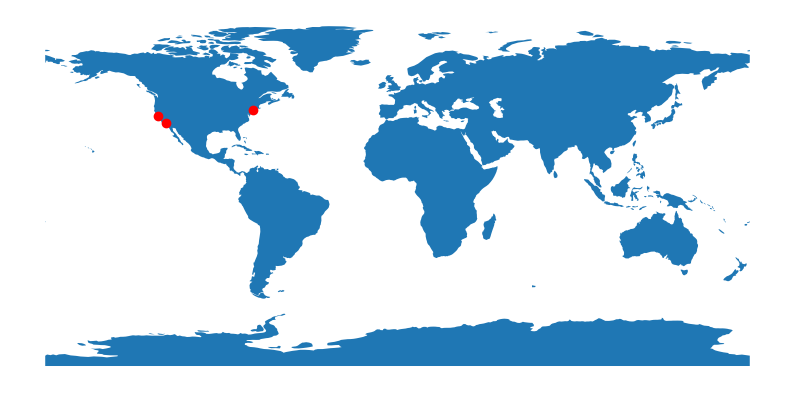

In [337]:
# Install geopandas if you haven't already


# Create a GeoDataFrame with points
data = {
    'City': ['San Francisco', 'Los Angeles', 'New York'],
    'Latitude': [37.7749, 34.0522, 40.7128],
    'Longitude': [-122.4194, -118.2437, -74.0060]
}

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data['Longitude'], data['Latitude'])
)

# Load a world basemap
world = gpd.read_file('maps/land_map.shp')

# Plot the world basemap and the points
ax = world.plot(figsize=(10, 6))
ax.axis('off')
gdf.plot(ax=ax, color='red')

plt.show()

In [ ]:
# Replace 'path_to_shapefile.shp' with the path to your custom shapefile
custom_map = gpd.read_file('path_to_shapefile.shp')

# Plot the custom map
ax = custom_map.plot(figsize=(10, 6))

# Add your points of interest (from the earlier gdf)
gdf.plot(ax=ax, color='red')

plt.show()